# Import des librairies

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [25]:
torch.cuda.is_available()

True

# Loading du modèle


In [26]:
model = fasterrcnn_resnet50_fpn(pretrained=True) # True pour fine tuning

# Number of classes (your dataset classes + 1 for background)
num_classes = 81  # For example, 2 classes + background (81 pour coco)

in_features = model.roi_heads.box_predictor.cls_score.in_features


model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

for param in model.backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Preparation du dataset

## Organisation du dataset

```
/dataset/
    /images/
        image_001.jpg
        image_002.jpg
        ...
    /annotations/
        image_001.txt
        image_002.txt
        ...
```


In [50]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Charge l'image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Charge l'annotation
        annotation_path = os.path.join(self.annotation_dir, img_name.replace(".jpg", ".txt"))
        boxes = []
        labels = []

        with open(annotation_path) as f:
            for line in f:
                label, x_min, y_min, x_max, y_max = map(float, line.strip().split())
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(label))

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [51]:
transform = T.Compose([
    T.ToTensor()
])

dataset = CustomDataset("dataset/images", "dataset/annotations", transforms=transform)

# Split en training et validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-80])
valid_dataset = torch.utils.data.Subset(dataset, indices[-20:])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)))


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/images'

## Pour coco

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [7]:
# Télécharger manuellement le dataset coco128 (en utilisant un script ultralytics)
from ultralytics.utils.downloads import download

download('https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip', unzip=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.66M/6.66M [00:00<00:00, 84.9MB/s]
Unzipping /content/coco128.zip to /content/coco128...: 100%|██████████| 263/263 [00:00<00:00, 1096.53file/s]


```coco128/
├── images/
│   ├── train2017/
│       ├── 000000000009.jpg
│       ├── ...
├── labels/  ← format YOLO (à ignorer pour Faster R-CNN)
│   ├── train2017/
│       ├── 000000000009.txt
├── annotations/
│   ├── instances_train2017.json  ✅ format COCO
```

In [7]:
import os
import json
from PIL import Image
from pathlib import Path

# Dossiers d'entrée
images_dir = Path("/content/coco128/images/train2017")
labels_dir = Path("/content/coco128/labels/train2017")

# Dictionnaire COCO de sortie
coco_dict = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Mapping YOLO class_id → label name
# Tu peux adapter cela avec les vrais noms si tu les as
coco_class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]
  # À adapter
for idx, name in enumerate(coco_class_names):
    coco_dict["categories"].append({
        "id": idx,
        "name": name,
        "supercategory": "object"
    })

annotation_id = 1  # ID global pour chaque annotation

for image_id, image_path in enumerate(sorted(images_dir.glob("*.jpg"))):
    # Charger l'image pour obtenir ses dimensions
    img = Image.open(image_path)
    width, height = img.size

    # Ajouter info image
    coco_dict["images"].append({
        "id": image_id,
        "file_name": image_path.name,
        "width": width,
        "height": height
    })

    # Correspondant .txt
    label_path = labels_dir / f"{image_path.stem}.txt"
    if not label_path.exists():
        continue

    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, w, h = map(float, parts)
            class_id = int(class_id)

            # Convertir en format COCO (bbox = [x_min, y_min, width, height])
            x_min = (x_center - w / 2) * width
            y_min = (y_center - h / 2) * height
            bbox_width = w * width
            bbox_height = h * height

            coco_dict["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": class_id,
                "bbox": [x_min, y_min, bbox_width, bbox_height],
                "area": bbox_width * bbox_height,
                "iscrowd": 0
            })
            annotation_id += 1

# Sauvegarder le fichier COCO
output_path = "/content/coco128/annotations/instances_train2017.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    json.dump(coco_dict, f, indent=2)

print(f"Annotations COCO sauvegardées dans {output_path}")


Annotations COCO sauvegardées dans /content/coco128/annotations/instances_train2017.json


L'étape précédente était nécessaire afin d'avoir le bon format de fichier.

In [8]:

from torchvision.datasets import CocoDetection
from torchvision import transforms as T

transform = T.Compose([
    T.ToTensor()
])

# COCO Dataset
cocodataset = CocoDetection(
    root='/content/coco128/images/train2017',
    annFile='/content/coco128/annotations/instances_train2017.json',
    transform=transform
)

# DataLoader avec collate_fn spécial
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    cocodataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [52]:
class CocoWrapper(torch.utils.data.Dataset):
    def __init__(self, coco_dataset):
        self.coco_dataset = coco_dataset

    def __getitem__(self, idx):
        img, targets = self.coco_dataset[idx]

        boxes = []
        labels = []
        for target in targets:
            # Vérifie si la boîte d'annotation est valide
            if 'bbox' in target:
                x, y, w, h = target['bbox']
                boxes.append([x, y, x + w, y + h])  # Conversion au format [x1, y1, x2, y2]
                labels.append(target['category_id'])  # ID de la catégorie

                # Si aucune boîte n'a été trouvée, crée un tensor vide pour les boîtes
        if len(boxes) == 0:
            boxes = torch.empty((0, 4), dtype=torch.float32)
            labels = torch.empty((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target_out = {
            'boxes': boxes,
            'labels': labels
        }


        return img, target_out

    def __len__(self):
        return len(self.coco_dataset)


In [53]:
# 📂 4. CHARGER LE DATASET

transform = T.Compose([
    T.ToTensor()
])

coco_dataset = CocoDetection(
    root='/content/coco128/images/train2017',
    annFile='/content/coco128/annotations/instances_train2017.json',
    transform=transform
)

wrapped_dataset = CocoWrapper(coco_dataset)

indices = torch.randperm(len(wrapped_dataset)).tolist()
train_dataset = Subset(wrapped_dataset, indices[:-80])
valid_dataset = Subset(wrapped_dataset, indices[-20:])

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False,
                          collate_fn=collate_fn, num_workers=2)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Training


In [54]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)
# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

   # Training loop
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    # Update the learning rate
    lr_scheduler.step()


    print(f'Epoch: {epoch + 1}, Loss: {train_loss / len(train_loader)}')
print("Training complete!")

Epoch: 1, Loss: 0.4777411992351214
Epoch: 2, Loss: 0.44513129939635593
Epoch: 3, Loss: 0.36607249702016514
Epoch: 4, Loss: 0.3074333493908246
Epoch: 5, Loss: 0.2948308475315571
Epoch: 6, Loss: 0.28186966727177304
Epoch: 7, Loss: 0.27587470039725304
Epoch: 8, Loss: 0.2761538277069728
Epoch: 9, Loss: 0.2753126646081607
Epoch: 10, Loss: 0.27545787456134957
Training complete!


# Evaluation du modèle

In [55]:
# Set the model to evaluation mode
model.eval()
# Test on a new image
with torch.no_grad():
    for images, targets in valid_loader:
        images = list(img.to(device) for img in images)
        predictions = model(images)
        # Example: print the bounding boxes and labels for the first image
        print(predictions[0]['boxes'])
        print(predictions[0]['labels'])

tensor([[141.6521, 119.1159, 415.1117, 636.2358],
        [ 55.0510,  65.2161, 270.2589, 640.0000],
        [107.0151,  88.5348, 372.3225, 565.9367]], device='cuda:0')
tensor([23, 23, 11], device='cuda:0')
tensor([[158.6719, 182.8057, 203.2756, 203.3578],
        [562.4106,  43.1079, 604.5594, 104.7117],
        [316.8009,  21.0245, 380.7426,  85.9579],
        [  9.7913,  97.2635, 139.2834, 357.7165],
        [261.5488, 182.2196, 379.9001, 573.0000],
        [496.8691, 205.2139, 616.7816, 248.1391],
        [219.9958,  54.5090, 252.3850, 102.5706],
        [436.7670, 504.4288, 453.3267, 520.8571],
        [526.3794,  58.2179, 559.6273, 106.8817],
        [154.4697,  45.5466, 213.0783, 104.5630],
        [ 28.9640, 400.4691,  75.9473, 460.7209],
        [476.5055, 199.7290, 617.7353, 215.3601],
        [464.0253, 191.7582, 633.9782, 271.7909],
        [528.6471,  54.1837, 559.3701, 104.1168],
        [449.8627,  34.1157, 531.3672,  97.5231],
        [321.5205, 397.9423, 365.9240, 518.0

In [45]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.4 MB/s eta 0:00:00


In [56]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Initialiser la métrique
metric = MeanAveragePrecision()

# Passer en mode évaluation
model.eval()

with torch.no_grad():
    for images, targets in valid_loader:  # valid_loader = DataLoader de validation
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Prédictions
        preds = model(images)

        # Torchmetrics attend des données sur CPU
        preds = [{k: v.cpu() for k, v in p.items()} for p in preds]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        # Mise à jour de la métrique
        metric.update(preds, targets)

# Affichage des résultats
print(metric.compute())


{'map': tensor(0.6069), 'map_50': tensor(0.8449), 'map_75': tensor(0.6705), 'map_small': tensor(0.3731), 'map_medium': tensor(0.6424), 'map_large': tensor(0.6844), 'mar_1': tensor(0.4755), 'mar_10': tensor(0.6235), 'mar_100': tensor(0.6414), 'mar_small': tensor(0.4152), 'mar_medium': tensor(0.6624), 'mar_large': tensor(0.7023), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  2,  4,  5,  6,  7,  9, 11, 13, 14, 15, 16, 17, 20, 22, 23, 25, 26,
        29, 31, 32, 33, 34, 36, 38, 39, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53,
        54, 56, 57, 58, 60, 62, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 77, 79],
       dtype=torch.int32)}


# Image random

In [57]:
import cv2
from PIL import Image
# Load image
img = Image.open("/content/rider.jpg")
# Apply the same transformation as for training
img = transform(img)
img = img.unsqueeze(0).to(device)
# Model prediction
model.eval()
with torch.no_grad():
    prediction = model(img)
# Print the predicted bounding boxes and labels
print(prediction[0]['boxes'])
print(prediction[0]['labels'])

tensor([[ 32.7846,  70.1544,  95.4007, 179.8689],
        [ 15.2695,  73.0282, 260.8357, 172.8520],
        [206.7480,  70.8328, 275.0000, 155.5176],
        [ 72.0604,  66.4514, 275.0000, 168.9931],
        [ 39.1760,  63.4131, 158.4930, 164.2097],
        [ 24.3214,  53.7791,  32.3518,  64.2739],
        [ 25.0288,  54.5188,  32.5796,  66.2855],
        [231.2655,  82.4592, 253.4521, 113.3014],
        [ 17.8048,  79.9368, 111.4449, 183.0000],
        [  3.8047,  35.6762, 119.4866, 183.0000]], device='cuda:0')
tensor([ 1,  3,  1,  1,  1, 67, 41, 17,  3, 38], device='cuda:0')


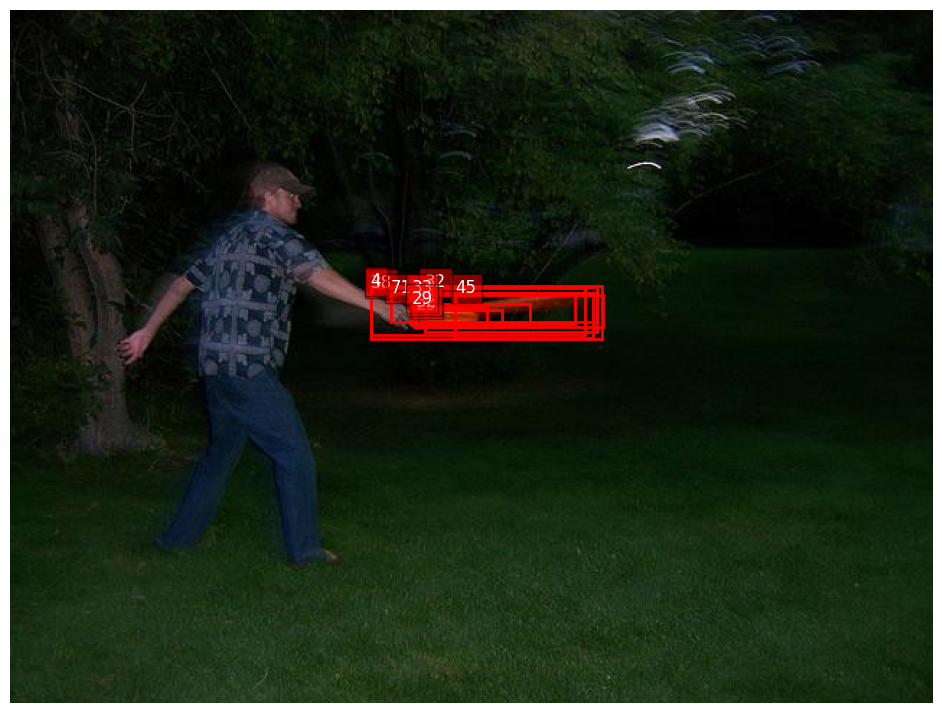

In [58]:
# Affichage sur la première image
img = images[0].cpu().permute(1, 2, 0).numpy()
pred = predictions[0]
boxes = pred['boxes'].cpu()
labels = pred['labels'].cpu()

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                             edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, f"{label.item()}", color='white', fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.show()

# Sauvegarde du modèle

In [59]:
torch.save(model.state_dict(), "fasterrcnn_coco128.pth")